In [1]:
import os
import sys
import shutil
import matplotlib.pyplot as plt

import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications.vgg19 import VGG19

MODEL_DIR = os.getcwd()
ROOT_DIR = os.path.dirname(MODEL_DIR)
DATA_DIR = os.path.join(ROOT_DIR, "data")
sys.path.append(MODEL_DIR)
from block import res_path, res_block, decoder_block

In [2]:
def TransResUNet(input_size=(512, 512, 3)):
    """
    TransResUNet -- main architecture of TransResUNet
    
    Arguments:
    input_size {tuple} -- size of input image
    
    Returns:
    model {<class 'tensorflow.python.keras.engine.training.Model'>} -- final model
    """
    
    # Input 
    inputs = Input(input_size)
    inp = inputs
    input_shape = input_size
    
    # Handling input channels 
    # input with 1 channel will be converted to 3 channels to be compatible with VGG16 pretrained encoder 
    if input_size[-1] < 3:
        inp = Conv2D(3, 1)(inputs)                         
        input_shape = (input_size[0], input_size[0], 3)  
    else:
        inp = inputs
        input_shape = input_size

    # VGG16 with imagenet weights
    encoder = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
       
    # First encoder block
    enc1 = encoder.get_layer(name='block1_conv1')(inp)
    enc1 = encoder.get_layer(name='block1_conv2')(enc1)
    # Second encoder block
    enc2 = MaxPooling2D(pool_size=(2, 2))(enc1)
    enc2 = encoder.get_layer(name='block2_conv1')(enc2)
    enc2 = encoder.get_layer(name='block2_conv2')(enc2)
    # Third encoder block
    enc3 = MaxPooling2D(pool_size=(2, 2))(enc2)
    enc3 = encoder.get_layer(name='block3_conv1')(enc3)
    enc3 = encoder.get_layer(name='block3_conv2')(enc3)
    enc3 = encoder.get_layer(name='block3_conv3')(enc3)

    # Center block
    center = MaxPooling2D(pool_size=(2, 2))(enc3)
    center = decoder_block(center, 512, 256)

    # Decoder block corresponding to third encoder
    res_path3 = res_path(enc3,128,3)
    dec3 = concatenate([res_path3, center], axis=3)
    dec3 = decoder_block(dec3, 256, 64)
    # Decoder block corresponding to second encoder
    res_path2 = res_path(enc2,64,2)
    dec2 = concatenate([res_path2, dec3], axis=3)
    dec2 = decoder_block(dec2, 128, 64)
    # Final Block concatenation with first encoded feature 
    res_path1 = res_path(enc1,32,1)
    dec1 = concatenate([res_path1, dec2], axis=3)
    dec1 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(dec1)
    dec1 = ReLU()(dec1)
    out = Conv2D(2, (1, 1), padding='same')(dec1)
    # Final model
    model = Model(inputs=[inputs], outputs=[out])
    
    return model

model = TransResUNet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'], run_eagerly=True)

In [3]:
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

TRAIN_IMG_DIR = os.path.join(TRAIN_DIR, "img")
TRAIN_MASK_DIR = os.path.join(TRAIN_DIR, "mask")
train_imgs = [os.path.join(TRAIN_IMG_DIR, png) for png in os.listdir(TRAIN_IMG_DIR)]
train_masks = [os.path.join(TRAIN_MASK_DIR, png) for png in os.listdir(TRAIN_MASK_DIR)]

TEST_IMG_DIR = os.path.join(TEST_DIR, "img")
TEST_MASK_DIR = os.path.join(TEST_DIR, "mask")
test_imgs = [os.path.join(TEST_IMG_DIR, png) for png in os.listdir(TEST_IMG_DIR)]
test_masks = [os.path.join(TEST_MASK_DIR, png) for png in os.listdir(TEST_MASK_DIR)]

In [4]:
train_img_files = tf.constant(train_imgs)
train_mask_files = tf.constant(train_masks)
train_dataset = tf.data.Dataset.from_tensor_slices((train_img_files, train_mask_files))

test_img_files = tf.constant(test_imgs)
test_mask_files = tf.constant(test_masks)
test_dataset = tf.data.Dataset.from_tensor_slices((test_img_files, test_mask_files))

(512, 512, 3)
(512, 512, 1)


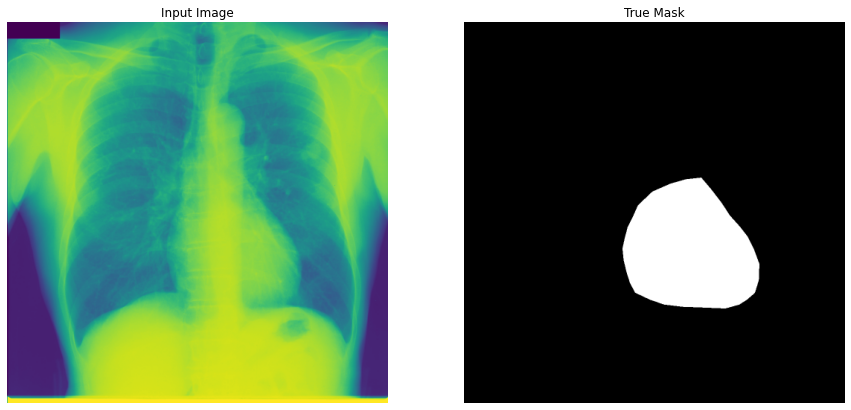

In [5]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (512, 512), method='nearest')
    input_mask = tf.image.resize(mask, (512, 512), method='nearest')

    return input_image, input_mask/255

#Train dataset
train_image_ds = train_dataset.map(process_path)
train_processed_image_ds = train_image_ds.map(preprocess)

test_image_ds = test_dataset.map(process_path)
test_processed_image_ds = test_image_ds.map(preprocess)

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask', 'Post Processed']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), 'gray')
        plt.axis('off')
    plt.show()

for image, mask in train_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(image.shape)
    print(mask.shape)

display([sample_image, sample_mask])

In [6]:
params = {
    "EPOCH": 50,
    "VAL_SUBSPLITS":3,
    "BUFFER_SIZE":500,
    "BATCH_SIZE":2,
}

train_processed_image_ds.batch(params["BATCH_SIZE"])
train_dataset = train_processed_image_ds.cache().shuffle(params["BUFFER_SIZE"]).batch(params["BATCH_SIZE"])
print(train_processed_image_ds.element_spec)

(TensorSpec(shape=(512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(512, 512, 1), dtype=tf.float32, name=None))


In [7]:
# Call-back 함수
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
LOG_DIR = os.path.join(ROOT_DIR, "logs")

# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(
    filepath=os.path.join(LOG_DIR, "VGG19-Augmentation-{epoch:03d}-{loss:.4f}-{accuracy:.4f}-{val_loss:.4f}-{val_accuracy:.4f}.hdf5"),
    monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'
)

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.9,patience=2, verbose=1, min_lr=1e-8)
# patience(3) 번 동안 validation set에서의 loss가 떨어지지 않으면, learning rate를 0.8만큼 곱해라
# 0.001 -> 0.0008 -> 0.00064 -> 0.00051xx...

CALLBACK = [CP, LR]

In [8]:
model_history = model.fit(
    train_dataset,
    epochs=params["EPOCH"],
    validation_data=test_dataset,
    verbose=True
)

Epoch 1/50
 1/93 [..............................] - ETA: 40:12 - loss: 0.5322 - accuracy: 0.9130

KeyboardInterrupt: 